In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import scipy.stats as stats

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization

In [2]:
df = pd.read_excel('../../data/tb_stock.xlsx')
df[['sc_date', 'sc_ss_stock']]

# 날짜 데이터를 유지
df['sc_date'] = pd.to_datetime(df['sc_date'])

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['sc_ss_stock'].values.reshape(-1, 1))
df['samsung_Close_Scaled'] = scaled_data

In [3]:
# 데이터셋을 훈련과 테스트로 분리
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# 시퀀스 데이터 생성 함수
def create_sequences_with_dates(data, dates, seq_length):
    X, y, y_dates = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
        y_dates.append(dates[i + seq_length])
    return np.array(X), np.array(y), np.array(y_dates)

# 50일치 데이터를 사용하여 다음 날을 예측
seq_length = 50

In [4]:
data = df['samsung_Close_Scaled'].values
dates = df['sc_date'].values
X, y, y_dates = create_sequences_with_dates(data, dates, seq_length)

X_train, X_test, y_train, y_test, y_train_dates, y_test_dates = train_test_split(X, y, y_dates, test_size=0.2, random_state=42, shuffle=False)

print(f'X_train shqpe : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shqpe : {X_train.shape}, y_test shape : {y_train.shape}')

X_train shqpe : (2856, 50), y_train shape : (2856,)
X_test shqpe : (2856, 50), y_test shape : (2856,)


In [5]:
# GRU 모델 정의
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0287 - val_loss: 0.0014
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0026 - val_loss: 5.6475e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0022 - val_loss: 4.0902e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0018 - val_loss: 3.9689e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0015 - val_loss: 9.0883e-04
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0018 - val_loss: 4.5240e-04
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0016 - val_loss: 3.6808e-04
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0016 - val_loss: 9.8097e-04
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0012 - val_loss: 5.5635e-04
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0013 - val_loss: 3.9858e-04
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0014 - val_loss: 4.0463e-04
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


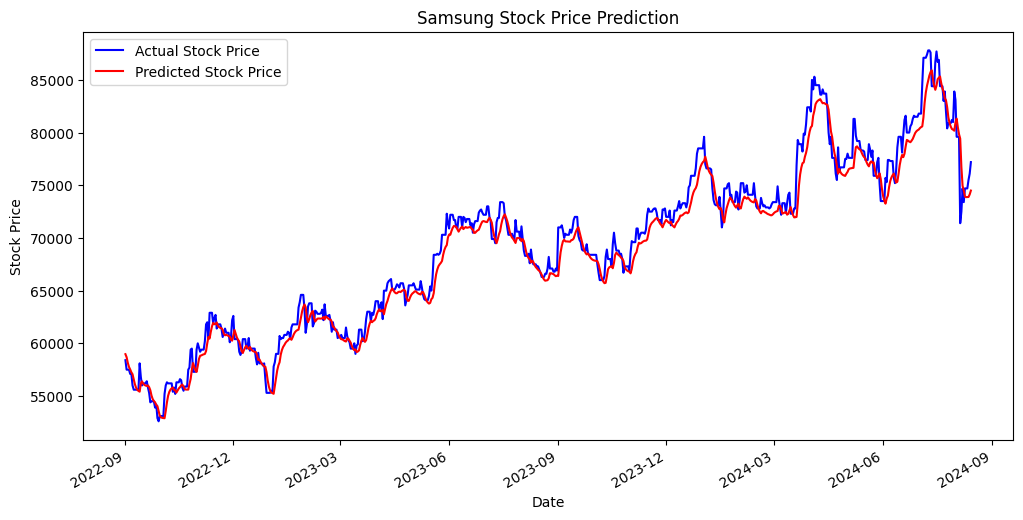

In [6]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(y_test_dates, predicted_stock_price, color='red', label='Predicted Stock Price')

# 한 달에 하나씩 날짜 표시 (간격을 월별로 설정)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('Samsung Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [7]:
# 모델 빌드 함수
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
                  return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
# 짧은 경로 설정
logging_dir = os.path.abspath('C:/my_dir')

if os.path.exists(logging_dir):
    shutil.rmtree(logging_dir)

os.makedirs(logging_dir)

In [9]:
# Keras Tuner 객체 생성
tuner = RandomSearch(
    build_model,
    objective           ='val_loss',
    max_trials          =50,              # 몇번 시도할건지 설정
    executions_per_trial=1,               # 각 조합을 더 많이 시도해 평균화
    directory           =logging_dir,
    project_name        ='gru_tuning'
)

c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# K-Fold 교차검증 설정
kf = KFold(n_splits=5)

In [11]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 교차검증 실행 및 최적 모델 탐색
best_fold = None
best_model = None
best_loss = float('inf')
best_hyperparameters = None

# 교차검증 실행
fold_no = 1
for train_index, test_index in tqdm(kf.split(X), desc='최적의 파라미터 찾기'):
    print(f'Training on fold {fold_no}...')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 모델 학습
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # 현재 폴드의 최적의 모델과 하이퍼파라미터 선택
    fold_best_model = tuner.get_best_models(num_models=1)[0]
    fold_best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # 현재 폴드의 모델 평가
    fold_loss = fold_best_model.evaluate(X_test, y_test)
    print(f'Fold {fold_no} - Loss: {fold_loss}')
    
    # 현재 폴드가 가장 좋은 성능을 보였다면, 해당 모델과 하이퍼파라미터 저장
    if fold_loss < best_loss:
        best_loss = fold_loss
        best_fold = fold_no
        best_model = fold_best_model
        best_hyperparameters = fold_best_hyperparameters
    
    fold_no += 1

Trial 50 Complete [00h 00m 33s]
val_loss: 5.494992001331411e-05

Best val_loss So Far: 4.975117917638272e-05
Total elapsed time: 00h 19m 37s


c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2300e-05


최적의 파라미터 찾기: 1it [19:38, 1178.76s/it]

Fold 1 - Loss: 4.975117917638272e-05
Training on fold 2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0867e-04


최적의 파라미터 찾기: 2it [19:40, 486.53s/it] 

Fold 2 - Loss: 0.00014464897685684264
Training on fold 3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5181e-04


최적의 파라미터 찾기: 3it [19:42, 265.27s/it]

Fold 3 - Loss: 0.00020664717885665596
Training on fold 4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5015e-04


최적의 파라미터 찾기: 4it [19:44, 161.33s/it]

Fold 4 - Loss: 0.000284876034129411
Training on fold 5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2147e-04


최적의 파라미터 찾기: 5it [19:46, 237.34s/it]

Fold 5 - Loss: 0.00031739610130898654


In [12]:
# 최적의 모델로 예측 수행
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,505 (584.00 KB)

 Trainable params: 149,505 (584.00 KB)

 Non-trainable params: 0 (0.00 B)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


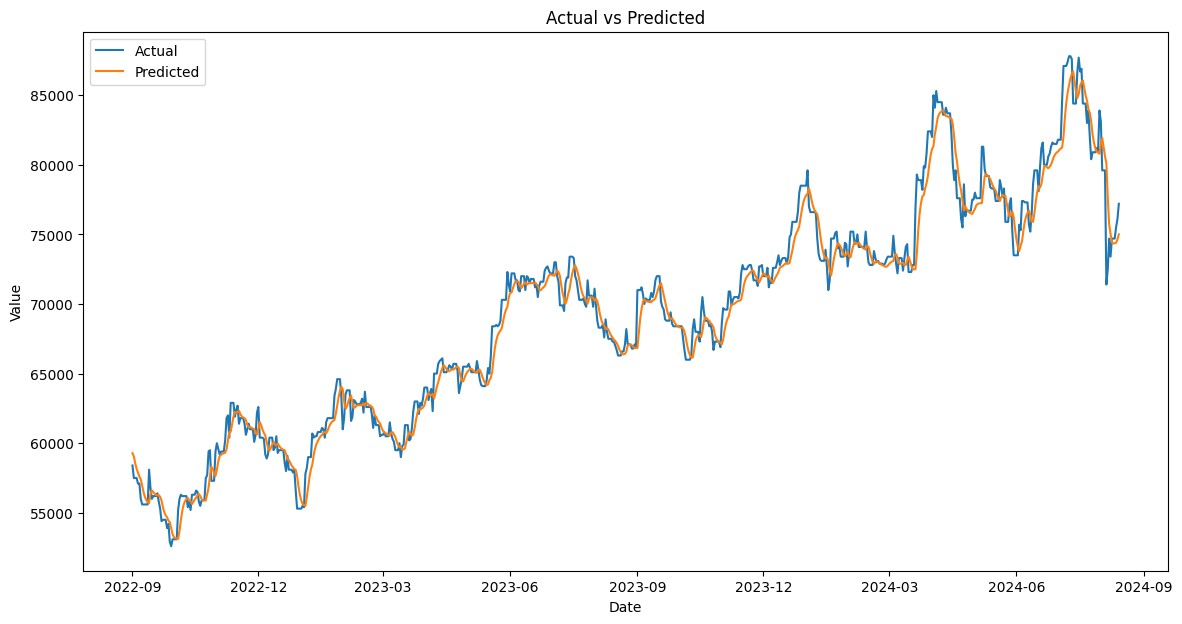

In [13]:
# 최적의 모델로 예측 수행
y_pred = best_model.predict(X_test)

# 예측 결과를 스케일링 원복
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과와 실제 값을 비교하는 그래프 그리기
plt.figure(figsize=(14, 7))

# x축에 날짜를 사용하여 실제 값과 예측 값을 그립니다.
plt.plot(y_test_dates, y_test_scaled, label='Actual')
plt.plot(y_test_dates, y_pred, label='Predicted')

# 한 달에 하나씩 날짜 표시 (간격을 월별로 설정)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()


In [19]:
y_pred

array([[59286.133],
       [59047.18 ],
       [58558.676],
       [58152.71 ],
       [57880.145],
       [57602.26 ],
       [57399.586],
       [56964.816],
       [56488.434],
       [56136.98 ],
       [55911.992],
       [55777.1  ],
       [55698.547],
       [56349.105],
       [56613.723],
       [56492.094],
       [56376.055],
       [56297.004],
       [56249.48 ],
       [56277.93 ],
       [56148.17 ],
       [55880.324],
       [55407.617],
       [55050.652],
       [54821.156],
       [54684.04 ],
       [54437.52 ],
       [54318.3  ],
       [53898.55 ],
       [53444.777],
       [53252.027],
       [53172.69 ],
       [53139.42 ],
       [53124.355],
       [53704.727],
       [54476.37 ],
       [55151.184],
       [55583.25 ],
       [55840.047],
       [55987.88 ],
       [56072.223],
       [55898.06 ],
       [55827.957],
       [55635.78 ],
       [55776.61 ],
       [55952.074],
       [56083.723],
       [56251.13 ],
       [56351.527],
       [56214.36 ],


Predicted next day price: 75001.9765625
Actual next day price: 77200.0


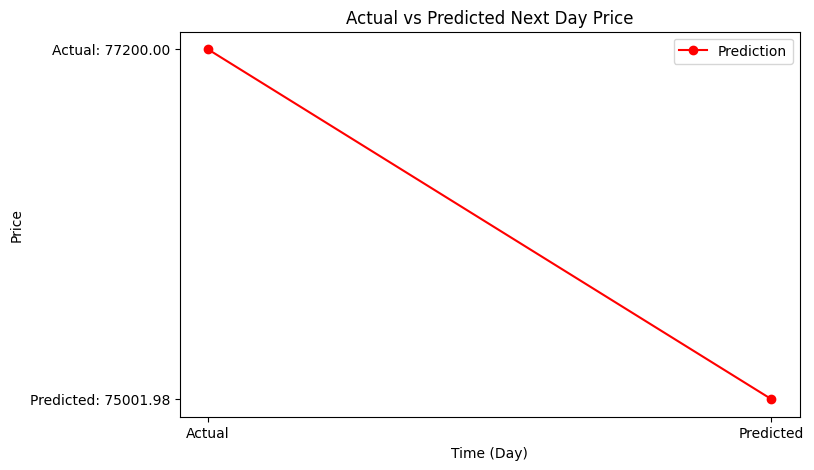

In [30]:
# 예를 들어, y_test의 마지막 값을 실제 다음 날의 가격으로 사용한다면:
actual_next_day_price_scaled = y_test[-1]    # 또는 적절한 인덱스를 사용
predicted_next_day_price_scaled = y_pred[-1] # 또는 적절한 인덱스를 사용

# 스케일링된 값을 원래 값으로 되돌리기 위해 scaler의 inverse_transform 사용
predicted_next_day_price_original = scaler.inverse_transform(predicted_next_day_price_scaled.reshape(-1, 1))[0][0]
actual_next_day_price_original = scaler.inverse_transform([[actual_next_day_price_scaled]])[0][0]

# 예측 결과 출력 (원래 값으로)
print(f"Predicted next day price: {predicted_next_day_price_original}")
print(f"Actual next day price: {actual_next_day_price_original}")

# 예측 결과와 실제 값을 비교
plt.figure(figsize=(8, 5))
plt.plot([1, 2], [actual_next_day_price_original, predicted_next_day_price_original], 'ro-', label='Prediction')
plt.title('Actual vs Predicted Next Day Price')
plt.xlabel('Time (Day)')
plt.ylabel('Price')

# y축에 실제 값 추가 (원래 값으로 표시)
plt.yticks([actual_next_day_price_original, predicted_next_day_price_original], 
           [f'Actual: {actual_next_day_price_original:.2f}', f'Predicted: {predicted_next_day_price_original:.2f}'])

plt.xticks([1, 2], ['Actual', 'Predicted'])
plt.legend()
plt.show()

In [23]:
# 예측 수행
y_pred = best_model.predict(X_test)

# 예측 결과를 스케일링 원복
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 성능 지표 계산
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 899.1133578431371
MSE: 1540169.480003592
RMSE: 1241.0356481598715
R²: 0.9758927026088658


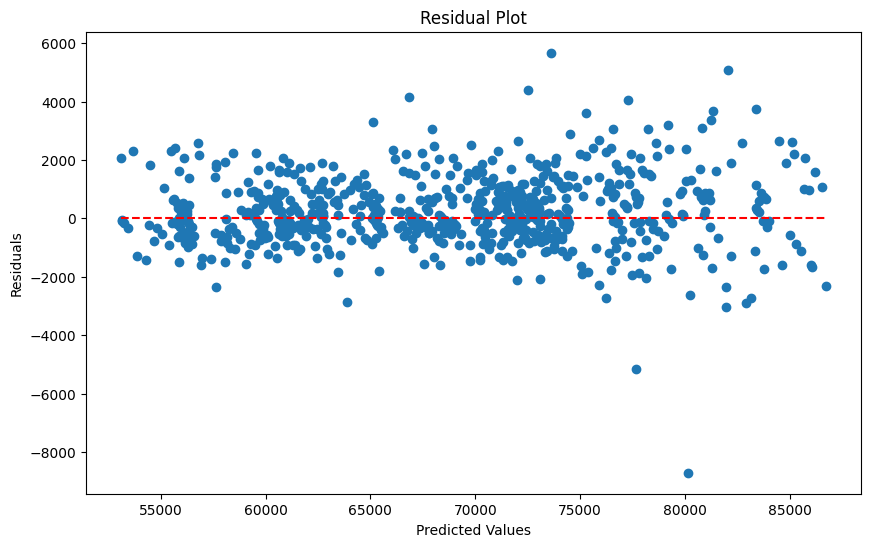

In [24]:
# 잔차 계산
residuals = y_test_scaled - y_pred

# 1. 잔차 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

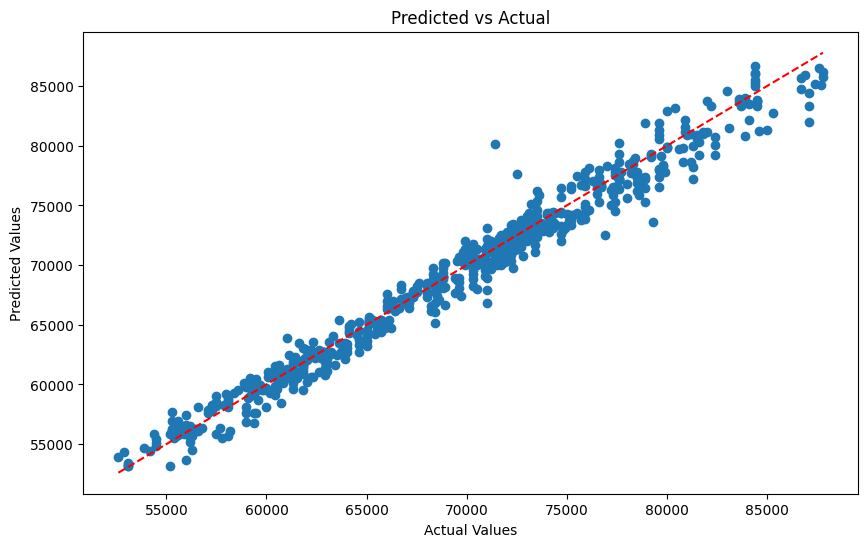

In [25]:
# 2. 예측 vs 실제 값 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_test_scaled, y_pred)
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

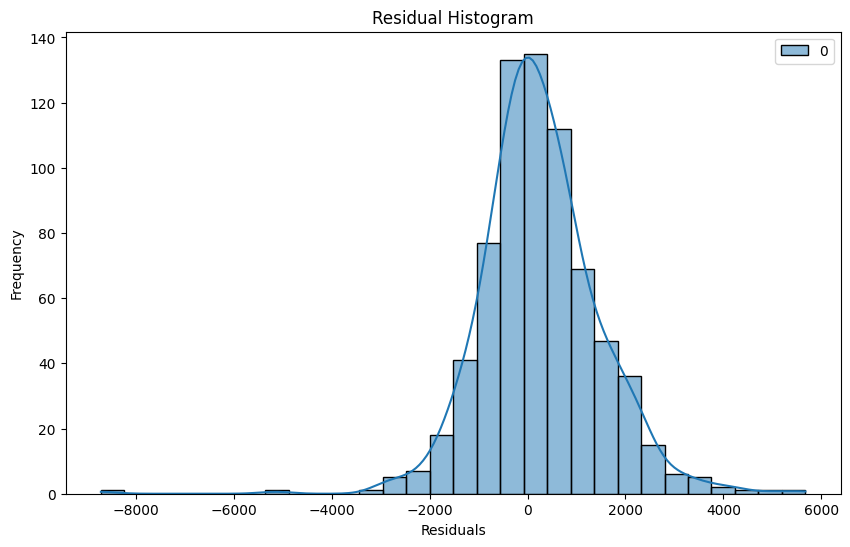

In [26]:
# 3. 잔차 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

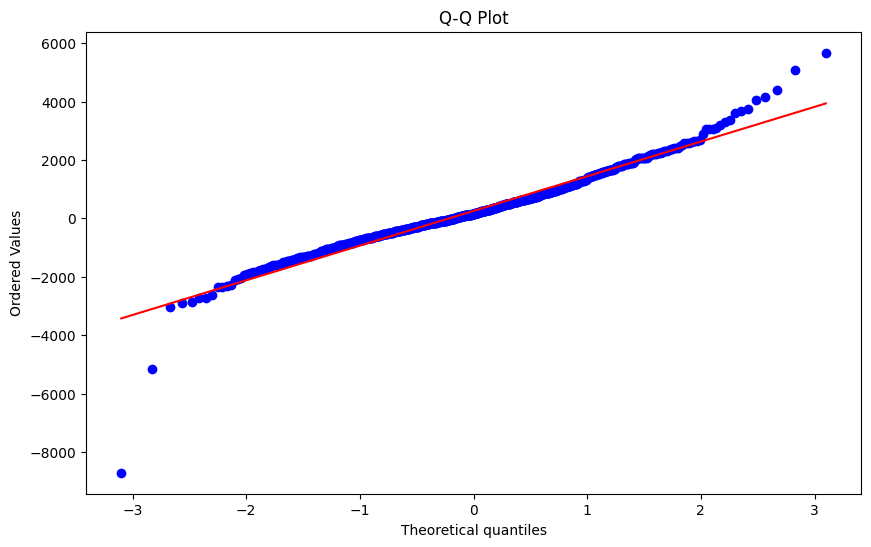

In [27]:
# 4. Q-Q 플롯
plt.figure(figsize=(10, 6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [28]:
# 최적의 하이퍼파라미터를 사용해 모델을 다시 학습
print(f'\nBest model found at fold {best_fold} with loss {best_loss}')
print(f'Best hyperparameters: {best_hyperparameters.values}')

# 최적의 모델을 다시 저장
final_model_save_path = "best_final_model.h5"
best_model.save(final_model_save_path)
print(f'Final best model saved at {final_model_save_path}')


Best model found at fold 1 with loss 4.975117917638272e-05
Best hyperparameters: {'units_1': 128, 'dropout_rate_1': 0.4, 'units_2': 128, 'dropout_rate_2': 0.5}
Final best model saved at best_final_model.h5
